# Sea level budget

In [16]:
import numpy as np
import sys
sys.path.append('../code')
import SeaLevelContrib as slc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import IPython.display
import importlib
import netCDF4
import xarray as xr
from time import gmtime, strftime

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [31]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

In [3]:
path_outputs = '../outputs/'

### Namelist

In [94]:
# Pick a region name (see choices bellow): 
tg_sel = 'NS_Fred16' # Tide gauge selection
opt_steric = ['EN4','ENS',4000] 
                # [0]: Poduct, only 'EN4' available so far
                # [1]: Region on which to average the steric effect: ENS, EBB, NWS
                # [2]: Depth of integration in meters
opt_glaciers = 'marzeion15' # marzeion15 for Marzeion et al. 2015
                            # zemp19 for Zemp et al. 2019
opt_antarctica = 'rignot19' # rignot19 or imbie18
opt_greenland = 'mouginot19' # No alternative yet but IMBIE is used in 
                             #Greenland.ipynb
opt_tws = 'humphrey19' # humphrey19 for Humphrey and Gudmundson 2019
#!!! Nodal cycle only included for regression method, not yet for dynamical model
opt_wind_ibe = ['regression','NCEP1'] # Method 'regression' or 'dynamical_model' 
                          # 'NCEP1': Regression to NCEP1 (1948 to now)
                          # 'ERA5' : Regression to ERA5 (1979 to now)
                          # 'WAQUA' : Use the barotropic ocean model WAQUA

INFO = True # Additional info on the computations

In [95]:
reg_dict = {'ZSM' : [20, 22, 23, 24, 25, 32], # Zeespiegelmonitor (Dutch coast)
            # North Sea Frederikse et al. 2016
            'NS_Fred16': [20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754],
            'Newlyn': [202], 
            'Brest': [1], 
            'Vlissingen': [20]}

tg_id = reg_dict[tg_sel]
tg_id

[20, 32, 236, 7, 80, 89, 302, 47, 830, 361, 95, 754]

### Budget

In [96]:
# Check the tide gauge data
tg_df = slc.tide_gauge_obs(tg_id, interp=True)
tg_df.iloc[-10:]

,20,32,236,7,80,89,302,47,830,361,95,754,Average
time,,,,,,,,,,,,,
2009,12.172611,9.902721,5.134694,13.770455,6.164286,-1.808621,1.629885,2.333333,3.579167,4.283333,7.959091,5.575,5.891330
2010,12.372611,8.702721,3.134694,11.870455,0.064286,-7.308621,-1.570115,-2.266667,2.745833,0.933333,8.809091,7.475,3.746885
2011,12.772611,11.802721,8.134694,17.770455,14.964286,3.191379,1.829885,4.333333,1.912500,1.933333,9.659091,8.075,8.031607
2012,12.072611,11.202721,6.534694,15.070455,10.364286,-0.508621,0.529885,1.133333,1.079167,2.933333,8.859091,6.475,6.312163
2013,10.672611,8.802721,3.334694,11.570455,-1.235714,-2.608621,-1.770115,-0.266667,1.979167,0.833333,8.759091,6.875,3.912163
2014,14.472611,13.502721,8.334694,15.070455,-6.035714,-4.208621,1.629885,4.033333,5.279167,5.333333,11.459091,7.875,6.395496
2015,14.772611,14.902721,11.434694,23.570455,18.064286,1.191379,2.329885,4.633333,5.279167,NaN,10.859091,8.675,10.519329
2016,15.072611,14.202721,8.934694,17.970455,13.264286,-3.708621,0.729885,1.733333,NaN,NaN,12.059091,NaN,8.917606
2017,16.672611,17.202721,12.634694,23.870455,18.364286,3.591379,3.529885,5.133333,NaN,NaN,13.959091,NaN,12.773162


In [97]:
slmean_df = slc.budget_at_tg(INFO, tg_id, opt_steric, opt_glaciers, opt_antarctica, 
                 opt_greenland, opt_tws, opt_wind_ibe, True)
slmean_df.iloc[-10:]

#slmean_df = slmean_df.loc[1958:2014] # Select date to fit Fred16 study


/Users/dewilebars/anaconda3/envs/p37ds/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Working on tide gauge id: 20
found point 52.37990188598633 3.75
Working on tide gauge id: 32
found point 52.37990188598633 3.75
Working on tide gauge id: 236
found point 54.28459930419922 5.625
Working on tide gauge id: 7
found point 54.28459930419922 9.375
Working on tide gauge id: 80
found point 56.189300537109375 9.375
Working on tide gauge id: 89
found point 58.09389877319336 9.375
Working on tide gauge id: 302
found point 58.09389877319336 7.5
Working on tide gauge id: 47
found point 58.09389877319336 5.625
Working on tide gauge id: 830
found point 59.998600006103516 358.125
Working on tide gauge id: 361
found point 58.09389877319336 358.125
Working on tide gauge id: 95
found point 54.28459930419922 358.125
Working on tide gauge id: 754
found point 52.37990188598633 1.875


,Total,Steric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,
2009,-0.464804,-0.108213,0.30975,1.598499,0.744895,0.002390,0.065577,-1.476151,-0.796830,-0.804721,2.902151
2010,-0.920558,0.684172,0.31500,1.628104,0.805626,0.002733,0.026453,-1.866720,-1.145756,-1.370170,0.757706
2011,1.246500,1.190268,0.32025,1.661646,0.870084,0.003110,-0.142243,-2.138122,1.345927,-1.864420,5.042429
2012,-0.082972,-0.772640,0.32550,1.692239,0.938399,0.003505,0.169377,-2.259721,1.083117,-1.262746,3.322984
2013,-1.374497,0.286472,0.33075,1.713928,1.010700,0.003853,0.166102,-2.217794,-0.719802,-1.948708,0.922984
2014,0.466792,1.462380,0.33600,1.743403,1.087119,0.004019,0.014262,-2.017071,-1.932825,-0.230494,3.406317
2015,2.862731,0.385113,0.34125,1.772879,1.167786,0.004268,0.046790,-1.680210,2.705763,-1.880907,7.530150
2016,1.097865,0.892871,0.34650,1.802354,1.252830,0.004529,0.046790,-1.245234,0.163970,-2.166745,5.928427
2017,6.888862,2.397211,0.35175,1.831830,1.342382,0.004840,0.046790,-0.761241,2.870311,-1.195011,9.783983


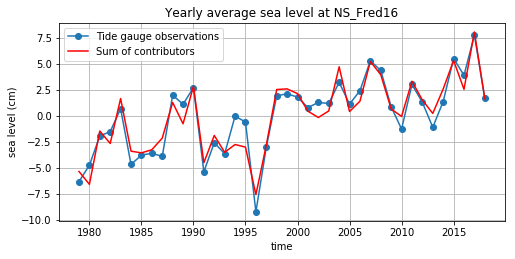

In [8]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(slmean_df.Obs - slmean_df.Obs.mean(), 'o-', label='Tide gauge observations')
ax.plot(slmean_df.Total - slmean_df.Total.mean() , 'r-', label='Sum of contributors')
#ax.plot(sealevel_df.index, sealevel_df['Nodal'], 'y-')
#ax.plot(sealevel_df.index, sealevel_df['Glaciers'], '-')
#ax.plot(TWS_df, '-')
ax.set_aspect(1)
#ax.set_xlim([ys,2020])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Yearly average sea level at '+tg_sel)
ax.grid(True)
plt.legend(loc='upper left')


Sum of difference (cm) : 
2.886579864025407e-15
Normalised root mean square error (cm): 
0.1717031809618637
Normalised absolute error (cm): 
0.8585738388084186


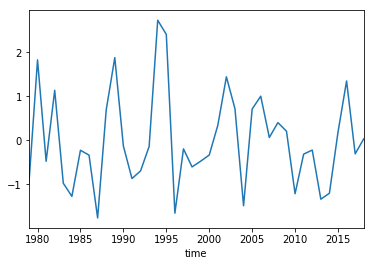

In [9]:
diff_df = slmean_df.Obs - slmean_df.Total
#diff_df = diff_df.loc[1979:]
#diff_df = diff_df.dropna()
diff_df = diff_df - diff_df.mean()
print('Sum of difference (cm) : ')
print(diff_df.sum())
print('Normalised root mean square error (cm): ')
print( np.sqrt( (diff_df**2).sum() ) / len(diff_df))
print('Normalised absolute error (cm): ')
print(np.abs(diff_df).sum() / len(diff_df))
#diff_df = diff_df.rolling( 3, center=True).mean()
diff_df.plot()

,Lin_trend,Acceleration
Total,1.998782,2.092725e-02
Steric,1.669653,-1.591763e-02
GIA,0.052500,1.439672e-16
Glaciers,0.281422,1.201594e-03
Antarctica,0.335317,2.228775e-02
Greenland,0.001270,1.048876e-04
TWS,0.072815,-3.609775e-03
Nodal,-0.129079,1.625969e-02
Wind,-0.233765,-4.801507e-03
Pressure,-0.051350,5.402235e-03


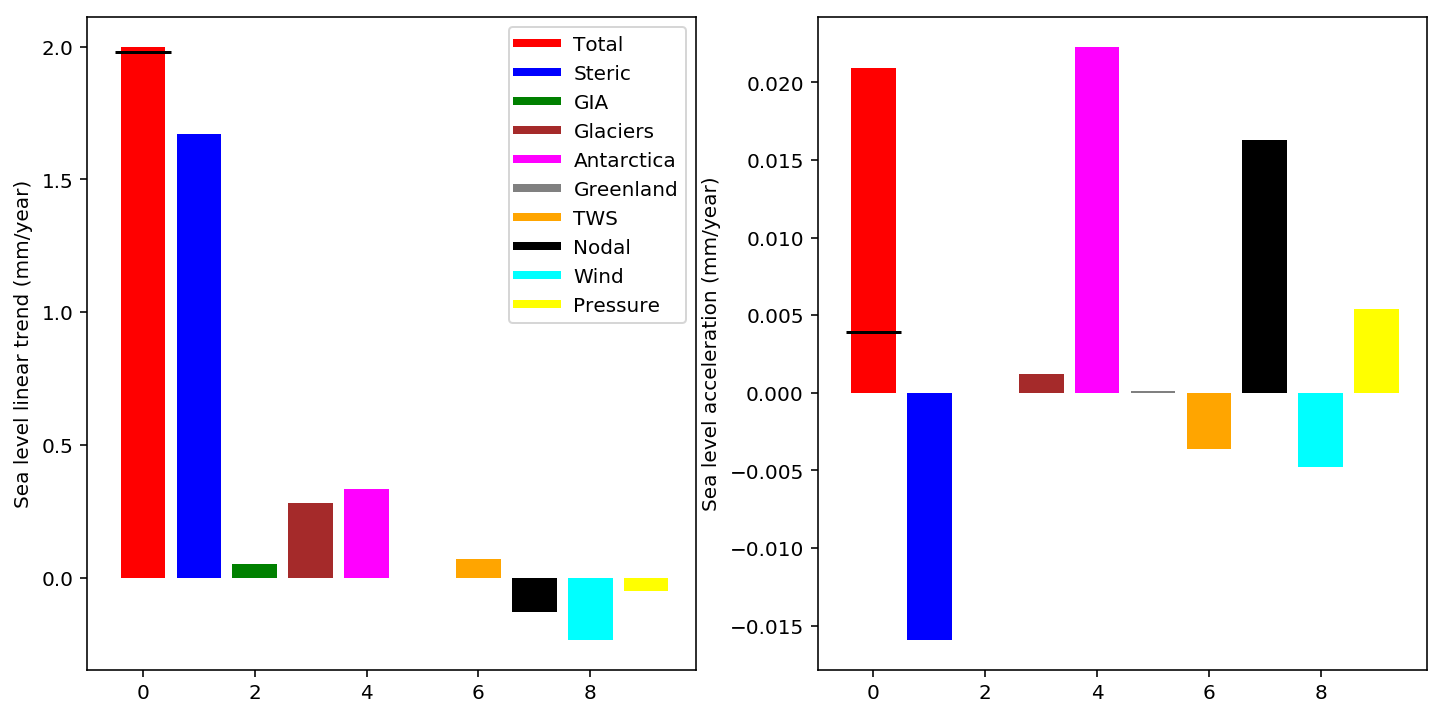

In [48]:
# Study the trend and acceleration budget
lin_trend = np.polyfit(slmean_df.index, slmean_df * 10, 1)[0,:]  # Convert from cm to mm
stat_df = pd.DataFrame(data = dict(Lin_trend = lin_trend), index=slmean_df.columns)

acceleration = 2 * np.polyfit(slmean_df.index, slmean_df * 10, 2)[0,:] # Convert from cm^2 / year to mm^2 / year
stat_df['Acceleration'] = acceleration

colors = ['red', 'blue', 'green', 'brown', 'magenta', 'grey', 'orange', 'black', 'cyan', 'yellow']
ind = np.arange(len(slmean_df.columns) - 1 )

legend_elements = []
for i in ind:
    legend_elements.append(Line2D([0], [0], color = colors[i], lw = 4, label = slmean_df.columns[i]))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(ind, lin_trend[:-1], color=colors)
ax[0].hlines(y=lin_trend[-1], xmin=-0.5, xmax=0.5, color='black')
ax[0].set_ylabel('Sea level linear trend (mm/year)')

ax[1].bar(ind, acceleration[:-1], color=colors)
ax[1].hlines(y=acceleration[-1], xmin=-0.5, xmax=0.5, color='black')
ax[1].set_ylabel('Sea level acceleration (mm/year)')

ax[0].legend(handles=legend_elements, loc='upper right')

stat_df

In the figure above the black bars represent the linear trend and accelartion computed from the tide gauges.

In [11]:
# Study the trend and acceleration budget
# Same as previous graph but split local and global steric effects
sl_g_df = slmean_df.copy()
sl_g_df['GloSteric'] =  slc.LevitusSL(extrap=True, extrap_back=True)
sl_g_df['Steric'] = sl_g_df['Steric'] - sl_g_df['GloSteric']
sl_g_df = sl_g_df.rename(columns={'Steric': 'LocSteric'})
# Rearange the columns for plotting
cols = sl_g_df.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
sl_g_df = sl_g_df[cols]

Text(0.5, 0.98, 'Sea level budget for the Dutch coast 1979-2018')

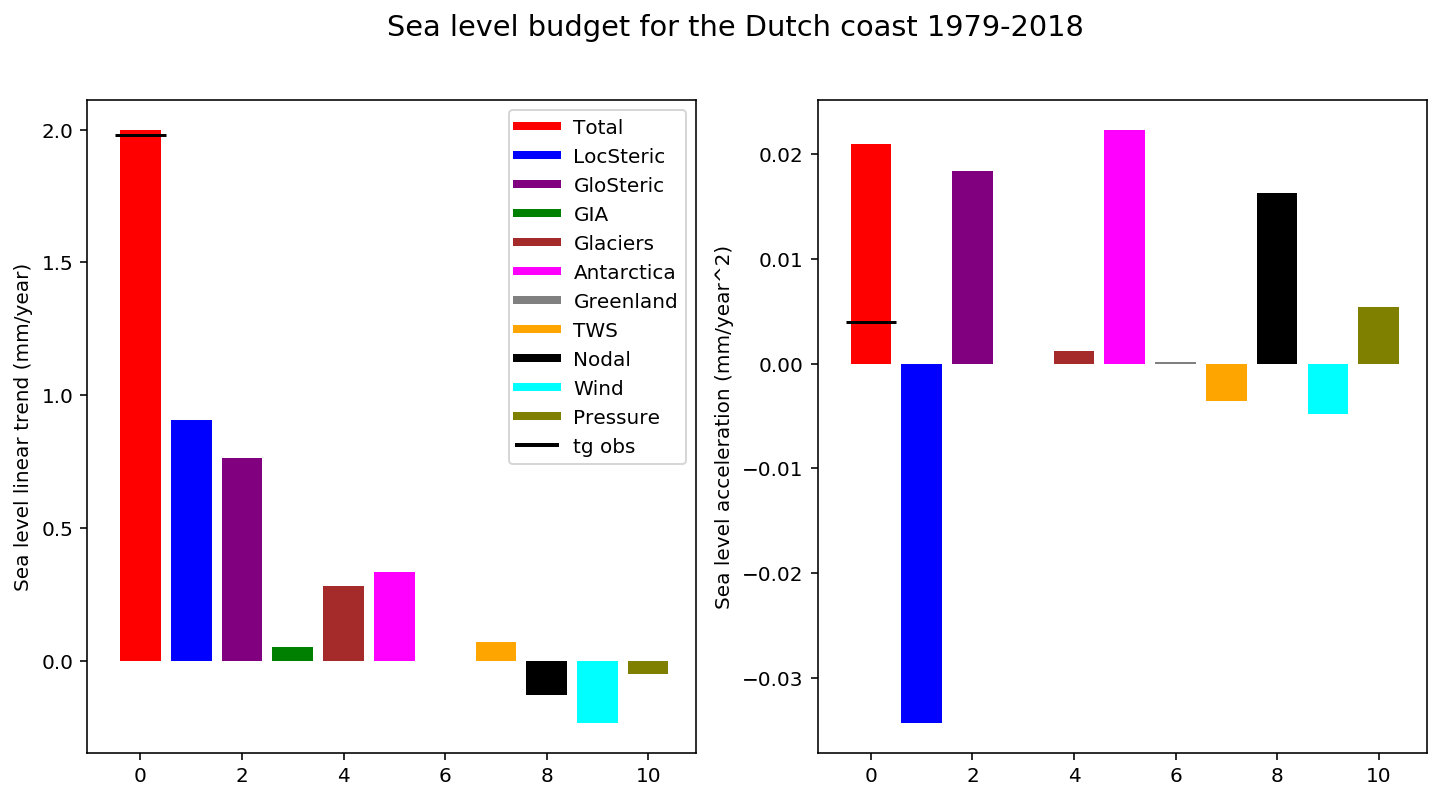

In [90]:
lin_trend = np.polyfit(sl_g_df.index, sl_g_df * 10, 1)[0,:]  
# Converted from cm to mm
stat_df = pd.DataFrame(data = dict(Lin_trend = lin_trend), index=sl_g_df.columns)

acceleration = 2 * np.polyfit(sl_g_df.index, sl_g_df * 10, 2)[0,:] 
# Convert from cm / year^2 to mm / year^2
stat_df['Acceleration'] = acceleration

colors = ['red', 'blue', 'purple', 'green', 'brown', 'magenta', 'grey', 
          'orange', 'black', 'cyan', 'olive']
ind = np.arange(len(sl_g_df.columns) - 1 )

legend_elements = []
for i in ind:
    legend_elements.append(Line2D([0], [0], color = colors[i], lw = 4, 
                                  label = sl_g_df.columns[i]))

legend_elements.append(Line2D([0], [0], color = 'black', lw = 2, 
                                  label = 'tg obs'))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(ind, lin_trend[:-1], color=colors)
ax[0].hlines(y=lin_trend[-1], xmin=-0.5, xmax=0.5, color='black')
ax[0].set_ylabel('Sea level linear trend (mm/year)')
#ax[0].set_title('tide gauge ?')

ax[1].bar(ind, acceleration[:-1], color=colors)
ax[1].hlines(y=acceleration[-1], xmin=-0.5, xmax=0.5, color='black')
ax[1].set_ylabel('Sea level acceleration (mm/year^2)')
#ax[1].set_title('tide gauge ?')

ax[0].legend(handles=legend_elements, loc='upper right')
#ax.set_xticks(ind)
fig.suptitle('Sea level budget for the Dutch coast 1979-2018', fontsize="x-large")

#!!! Modify the name if necessary:
#sl_g_df.to_csv(path_outputs+'SLBudget_Steric4000m_ERA5_1979_2018_withLocSteric.csv')


In [91]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

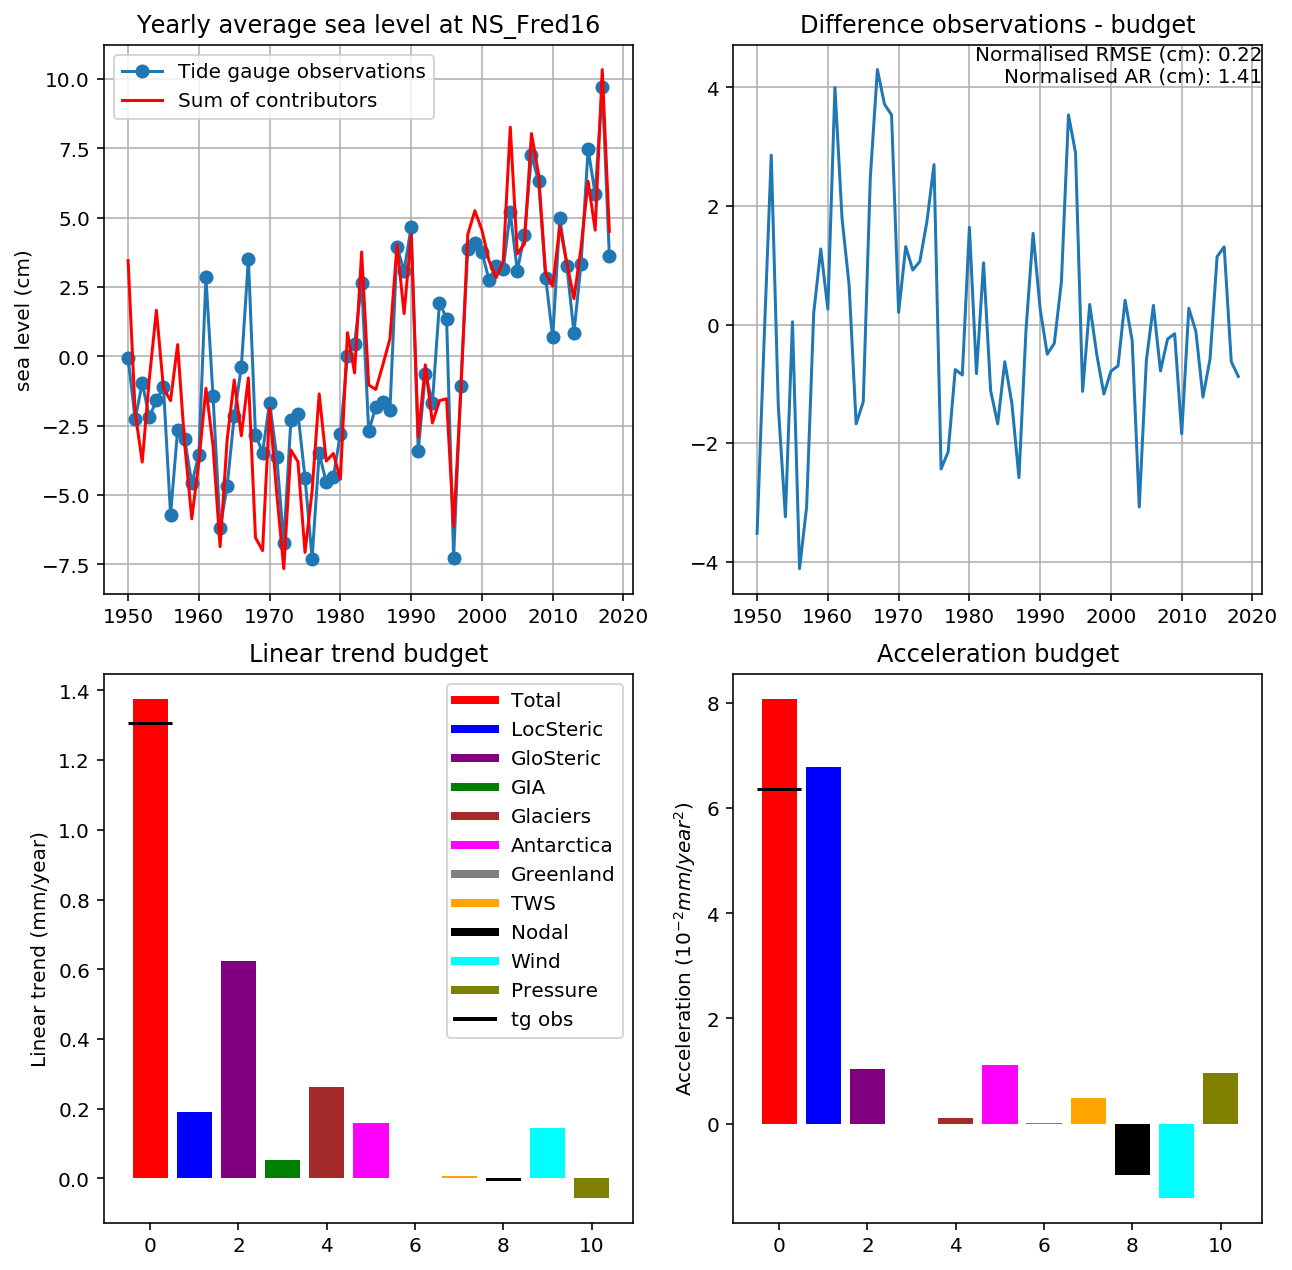

In [98]:
separate_global_steric = True
fig, ax = slc.plot_budget(tg_sel, slmean_df, separate_global_steric)
#plt.savefig('Figures/CompObsContrib.pdf')

In [99]:
budget_name = 'slbudget_'+strftime("%Y_%m_%d", gmtime())+'_'+tg_sel+'_'+str(slmean_df.index[0])+'_'+str(slmean_df.index[-1])+'_'+opt_wind_ibe[1]+''

# Write out a budget csv file
slmean_df.to_csv(path_outputs+budget_name+'.csv')

# Write out the figure
fig.savefig(path_outputs+budget_name+'.pdf', bbox_inches='tight') #pad_inches=2

# Write budget info to a text file
text_out = ('Budget information: \n'
            'Tide gauge selection: '+tg_sel+' \n'
            'Corresponding to ids: '+str(tg_id)+' \n'
            'Period: '+str(slmean_df.index[0])+'-'+str(slmean_df.index[-1])+' \n'
            'Steric contribution: '+str(opt_steric)+' \n'
            'Glaciers: '+opt_glaciers+' \n'
            'Antarctica:'+opt_antarctica+' \n'
            'Greenland: '+opt_greenland+' \n'
            'Terrestrial water storage: '+opt_tws+' \n'
            'Wind and inverse barometer effect: '+str(opt_wind_ibe)+' \n'
           )

file = open(path_outputs+budget_name+'.txt','w') 
file.write(text_out)
file.close()

# Alternative for better tracability:
# Generate a unique number that describes the budget, number the options and give an order:21324

### Some remarks

Comment on the choice of steric expansion location:
It seems that using the Bay of Biscay reduces the eror compared to extended North Sea.
On the other hand Norwegian Sea increases it.

Antarctica: 
Rignot et al. 2019 -> 0.315, 1.96
IMBIE 2018 -> 0.319, 1.99
More acceleration seems better

Using pressure as a regressor improves the budget closure. N. RMS: 0.308, N. AE: 1.93 

I had forgotten to add the nodal cycle. Including it improves the fit!

Computing the wind, nodal and pressure effects (linear fit) after removing the trend from the reconstruction improves the fit compared to computing the fit using a linear trend.

Using ERA5 leads to improve the model significantly, for the period 1979 and after:
- ERA5: rmse = 0.21, ae = 1.08
- NCEP1: rmse = 0.24, ae = 1.21

Using the extended Bay of Biscay area, mostly solves the trend problem but it introduces higher rms (0.27) and ae (1.30).

The same conclusion applies to stopping the integration of steric effect at 60N instead of the standard 69N. This is because steric trend in the region 60-69 is smaller than further South (see the Steric notebook). What is the most relevent for the North Sea?

Using sea level from WAQUA forced by ERA-interim increases the rmse (0.26) and ae (1.35) compared to linear regressions to ERA5 or NCEP1 reanalysis. This might be because of sea level variations external to the domain entering the domain.

One possible difference between KNMI projections and Deltares zsm is the vertical land motion: GIA from ICE6G provides 0.36mm/y for the Dutch tide gauges while 0.45 was used in the ZSM. That is still not much: 2 mm in 20 years.

The computation of acceleration is very sensitive to the period used to compute it even for the steric effect. Also it seems very difficult to get right. For example at the Brest tide gauge, observations show a deceleration while the budget shows an acceleration.
This points toward the need to consider longer time periods to study the acceleration.

Even in the period 1950-2017 the acceleration is difficult to get right. For the Dutch coast the budget gives twice larger values than the tide gauge observations. For that period it seems that for Newlyn, Brest and Dutch coast the trend is underestimated and the acceleration is overestimated.

Acceleration for the Dutch coast is very sensitive to the wind and steric effects: check starting point in 1950 compared to 1958 -> Also check over the ERA5 period